<a href="https://colab.research.google.com/github/yoooniverse/NLP/blob/main/RecommendationSystemDocumentEmbedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문서 내 각 단어들을 Word2Vec을 통해 단어 벡터로 변환하고, 이들의 평균으로 문서 벡터를 얻어 선호하는 도서와 유사한 도서를 찾아주는 도서 추천 시스템

In [6]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('total # of data: ', len(df))

total # of data:  2382


In [4]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


column 'Desc' : summary

preprocessing for the 'Desc' column

In [7]:
def _removeNonAscii(s):
  return "".join(i for i in s if ord(i)<128)

def make_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  text = text.split()
  stops = set(stopwords.words("english"))
  text = [w for w in text if not w in stops]
  text = " ".join(text)
  return text

def remove_html(text):
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r'', text)

def remove_punctuation(text):
  tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
  text = tokenizer.tokenize(text)
  text = " ".join(text)
  return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_html)
df['cleaned'] = df.cleaned.apply(remove_punctuation)

In [8]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [9]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('total # of data : ', len(df))

total # of data :  2381


In [10]:
corpus = []
for words in df['cleaned']:
  corpus.append(words.split())

In [12]:
word2vec_model = Word2Vec(size = 300, window = 5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('/content/drive/MyDrive/NLP/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples=word2vec_model.corpus_count, epochs=15)

(0, 0)

In [15]:
def get_document_vectors(document_list):
  document_embedding_list = []

  for line in document_list:
    doc2vec = None
    count = 0

    for word in line.split():
      if word in word2vec_model.wv.vocab:
        count+=1
        if doc2vec is None:
          doc2vec = word2vec_model[word]
        else:
          doc2vec = doc2vec + word2vec_model[word]
    if doc2vec is not None:
      doc2vec = doc2vec / count
      document_embedding_list.append(doc2vec)
  
  return document_embedding_list

In [16]:
document_embedding_list = get_document_vectors(df['cleaned'])
print('# of document vectors : ', len(document_embedding_list))

<ipython-input-15-13fb29d8d22b>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
<ipython-input-15-13fb29d8d22b>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


# of document vectors :  2381


recommendation system

In [17]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('cosine similarity matrix shape: ', cosine_similarities.shape)

cosine similarity matrix shape:  (2381, 2381)


In [20]:
def recommendation(title):
  books = df[['title', 'image_link']]

  indices = pd.Series(df.index, index = df['title']).drop_duplicates()
  idx = indices[title]

  sim_scores = list(enumerate(cosine_similarities[idx]))
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
  sim_scores = sim_scores[1:6]

  book_indices = [i[0] for i in sim_scores]

  recommend = books.iloc[book_indices].reset_index(drop=True)

  fig = plt.figure(figsize=(20,30))

  for index, row in recommend.iterrows():
    response = requests.get(row['image_link'])
    img = Image.open(BytesIO(response.content))
    fig.add_subplot(1, 5, index + 1)
    plt.imshow(img)
    plt.title(row['title'])

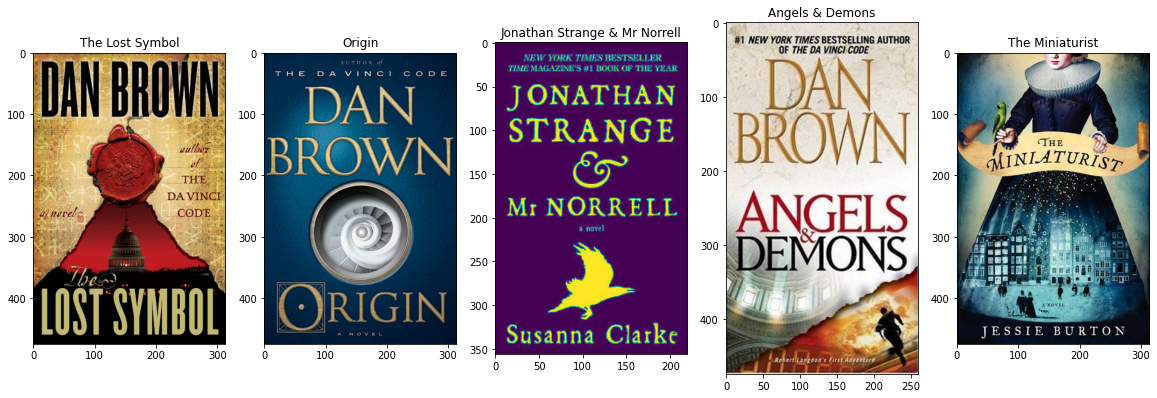

In [21]:
recommendation("The Da Vinci Code")